In [1]:

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization

from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(128,128, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(25, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

train_datagen = ImageDataGenerator(rescale = None,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('LeafDisease_2/dataset/train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')




test_set = test_datagen.flow_from_directory('LeafDisease_2/dataset/test',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

labels = (training_set.class_indices)
labels2 = (test_set.class_indices)

# Calculate steps per epoch and validation steps
batch_size = 30
total_train_samples = len(training_set.filenames)
total_test_samples = len(test_set.filenames)
steps_per_epoch = total_train_samples // batch_size
validation_steps = total_test_samples // batch_size

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with adjusted steps_per_epoch and early stopping
model.fit(training_set,
          steps_per_epoch=steps_per_epoch,
          epochs=100, 
          validation_data=test_set,
          validation_steps=validation_steps,
          callbacks=[early_stopping])

model_json=model.to_json()
with open("model_leaf.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
    model.save_weights("model_leaf.h5")
    print("Saved model to disk")
    
    

In [1]:
import cv2
import numpy as np
from keras.models import model_from_json

# Load the trained model from the saved files
json_file = open('model_leaf.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into the model
loaded_model.load_weights('model_leaf.h5')

# Define the labels
labels = {
    0: 'Apple___Apple_scab',
    1: 'Apple___Black_rot',
    2: 'Apple___Cedar_apple_rust',
    3: 'Apple___Healthy',
    4: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    5: 'Corn_(maize)___Common_rust',
    6: 'Corn_(maize)___Healthy',
    7: 'Corn_(maize)___Northern_Leaf_Blight',
    8: 'Grape___Black_rot',
    9: 'Grape___Esca_(Black_Measles)',
    10: 'Grape___Healthy',
    11: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    12: 'Potato___Early_blight',
    13: 'Potato___Healthy',
    14: 'Potato___Late_blight',
    15: 'Tomato___Bacterial_spot',
    16: 'Tomato___Early_blight',
    17: 'Tomato___Healthy',
    18: 'Tomato___Late_blight',
    19: 'Tomato___Leaf_Mold',
    20: 'Tomato___Septoria_leaf_spot',
    21: 'Tomato___Spider_mites Two-spotted_spider_mite',
    22: 'Tomato___Target_Spot',
    23: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    24: 'Tomato___Tomato_mosaic_virus'
}


Image captured!


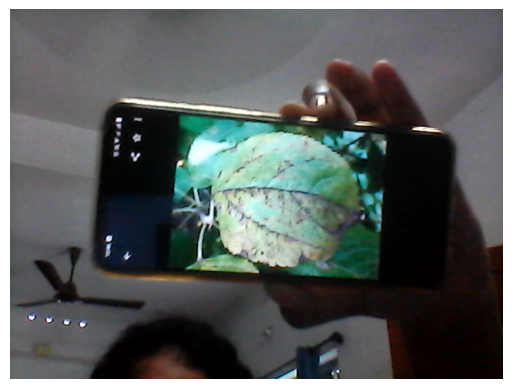

In [1]:
import cv2
import matplotlib.pyplot as plt
# Open the webcam
cap = cv2.VideoCapture(0)

# Give the camera time to warm up
cv2.waitKey(1000)

while True:
    # Capture a single frame
    ret, frame = cap.read()

    # Display the live webcam feed
    cv2.imshow("Webcam Feed", frame)

    # Check for key presses
    key = cv2.waitKey(1)

    # Capture image when 'c' is pressed
    if key == ord('c'):
        cv2.imwrite("captured_image.jpg", frame)
        print("Image captured!")
        
         # Display the captured image using matplotlib
        captured_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(captured_image)
        plt.axis('off')
        plt.show()

    # Quit the program when 'q' is pressed
    elif key == ord('q'):
        break

# Release the camera
cap.release()

# Close all windows
cv2.destroyAllWindows()


In [3]:

# Load the captured image
img = cv2.imread("captured_image.jpg")

# Resize the image to a standard size (e.g., 128x128)
img = cv2.resize(img, (128, 128))

# Preprocess the image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
img = np.expand_dims(img, axis=0)

# Make a prediction
prediction = loaded_model.predict(img)

# Get the predicted label
predicted_label = labels[np.argmax(prediction)]

# Display the result
print(f'Prediction: {predicted_label}')
# Determine if the prediction is healthy or diseased
if "Healthy" in predicted_label:
    result_text = "Healthy"
else:
    result_text = "Diseased"
    
# Write the predicted label on the image
img = cv2.imread("captured_image.jpg")
cv2.putText(img, f'Prediction: {result_text}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display the result
cv2.imshow("Prediction Result", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 25ms/step
Prediction: Corn_(maize)___Common_rust
